In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

!pip install fastai duckduckgo_search

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('goat photos', max_images=1)
urls[0]

Searching for 'goat photos'


'https://thetiltedglass.com/assets/cms/images/goat-worship-4.jpg'

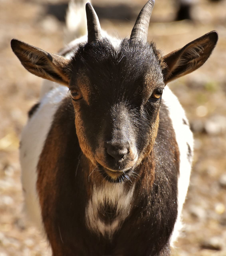

In [6]:
from fastdownload import download_url
dest = 'goat.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'sheep photos'


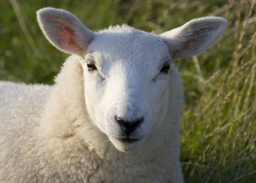

In [8]:
download_url(search_images('sheep photos', max_images=1)[0], 'sheep.jpg', show_progress=False)
Image.open('sheep.jpg').to_thumb(256,256)

In [9]:
searches = 'sheep','goat'
path = Path('sheep_or_goat')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} barn photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} cute photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'sheep photo'
Searching for 'sheep barn photo'
Searching for 'sheep cute photo'
Searching for 'goat photo'
Searching for 'goat barn photo'
Searching for 'goat cute photo'


In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

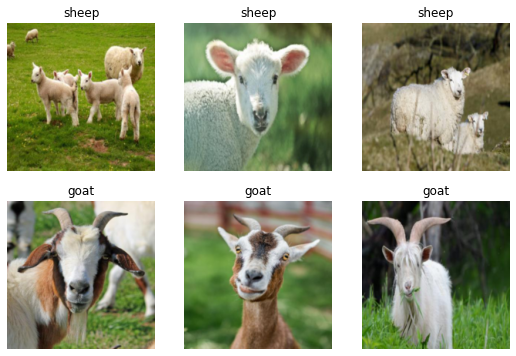

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/jong/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jong/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jong/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.056116,0.492521,0.257143,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.637203,0.303294,0.085714,00:09
1,0.389261,0.338395,0.057143,00:09
2,0.306152,0.339927,0.085714,00:09


In [15]:
is_bird,_,probs = learn.predict(PILImage.create('goat.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a goat: {probs[0]:.4f}")

This is a: goat.
Probability it's a goat: 0.9863


In [16]:
is_bird,_,probs = learn.predict(PILImage.create('sheep.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a goat: {probs[0]:.4f}")

This is a: sheep.
Probability it's a goat: 0.0046


In [19]:
is_bird,_,probs = learn.predict(PILImage.create('/mnt/c/Users/Jonathan/Downloads/becca_linkedin.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a goat: {probs[0]:.4f}")

This is a: goat.
Probability it's a goat: 0.7925


In [23]:
is_bird,_,probs = learn.predict(PILImage.create('/mnt/c/Users/Jonathan/Downloads/jeremy.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a goat: {probs[0]:.4f}")

This is a: goat.
Probability it's a goat: 0.6689
